# Итоговая работа по курсу "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Python для Data Science. Градиентный бустинг изучается
в последующих курсах, поэтому в этом проекте его применять не следует.
Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

In [265]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

In [266]:
# создание функций

def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [267]:
# загрузка данных

train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
print("data is loaded")

data is loaded


In [109]:
print(f"Train:\t{train.shape[0]}\t sales and {train.shape[1]} features")
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [110]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [111]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [112]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [113]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

##### оптимизация использования памяти

In [114]:
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')

In [115]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [116]:
train = optimizing_df(train)
test = optimizing_df(test)

In [117]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  uint8   
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [118]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   uint8   
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   uint8   
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

In [119]:
# проверка  данных

all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [120]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,15000.0,8393.136933,4850.111673,0.000000,4188.750000,8378.500000,12594.250000,1.679800e+04
DistrictId,15000.0,50.693600,43.786257,0.000000,20.000000,37.000000,75.000000,2.120000e+02
Rooms,15000.0,1.897000,0.839229,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,15000.0,56.360352,20.423912,1.136859,41.814370,52.645758,66.036606,6.410652e+02
LifeSquare,11846.0,36.851791,71.120186,0.333490,22.896130,32.822811,45.144627,7.480592e+03
KitchenSquare,15000.0,6.174467,24.016979,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,15000.0,8.561800,5.323113,1.000000,4.000000,7.000000,12.000000,7.800000e+01
HouseFloor,15000.0,12.606600,6.780165,0.000000,9.000000,12.000000,17.000000,1.170000e+02
HouseYear,15000.0,3321.575067,163707.780381,1908.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,15000.0,0.119196,0.119371,0.000000,0.017647,0.075424,0.195781,5.218670e-01


In [121]:
# корректирровка комнат

all_data.loc[all_data['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
377,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,NaN,5,15,B
1454,8491,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,B,B,1,264,0,NaN,0,1,B
8849,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,B,B,25,5648,1,30.0,2,4,B
13398,1435,111,17,52.866108,32.528343,8.0,15,17,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [122]:
all_data.loc[all_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1397,12638,27,0,138.427689,136.215500,0.0,4,3,2016,0.075424,B,B,11,3097,0,NaN,0,0,B
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
2269,7317,27,0,41.790882,NaN,0.0,13,0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B
4366,456,6,0,81.491447,NaN,0.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,NaN,3,9,B
8834,9443,27,0,87.762619,85.125473,0.0,5,15,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
12406,3343,58,0,116.824203,113.692421,0.0,3,3,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
12524,10729,27,0,76.345154,42.820797,12.0,14,0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [123]:
def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)

    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

In [124]:
# далее - корректировка площади

all_data.loc[all_data['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6977,11602,30,2,641.065186,638.163208,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B
4262,28,9,2,604.705994,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
4690,2307,102,1,409.425171,410.639740,10.0,4,4,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
1982,5548,86,5,275.645294,233.949310,26.0,12,37,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B
13217,4058,27,6,223.453690,104.113556,16.0,2,2,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
13909,1397,76,3,221.138763,118.055344,4.0,32,48,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
9910,16568,27,4,200.334534,201.627365,25.0,1,2,2013,0.041116,B,B,53,14892,4,NaN,1,4,B


mu = 56.36 and sigma = 20.42


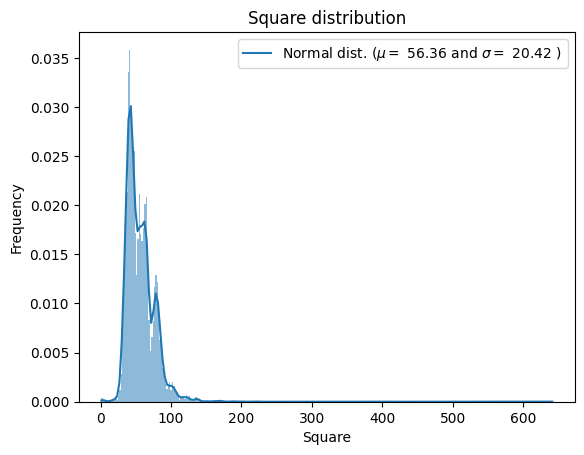

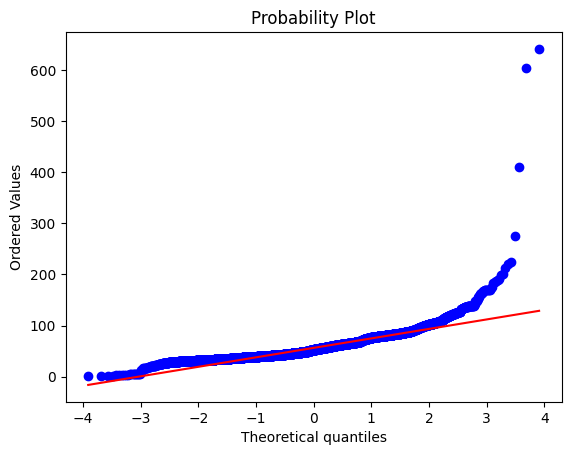

In [125]:
sns.histplot(all_data['Square'], kde=True, stat="density", linewidth=0)

# Подгонка нормального распределения
mu, sigma = norm.fit(all_data['Square'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend([f'Normal dist. ($\\mu=$ {mu:.2f} and $\\sigma=$ {sigma:.2f} )'])
plt.ylabel('Frequency')
plt.title('Square distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['Square'], plot=plt)
plt.show()

In [126]:
def df_fix_square_manual(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    return df

In [127]:
def df_fix_square(df):
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

In [128]:
def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df


def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

#### годы ремонта

In [129]:
all_data.loc[all_data['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1497,10814,109,1,37.265072,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
4189,11607,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [130]:
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

### обработка данных

In [131]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

mu = 56.36 and sigma = 20.42


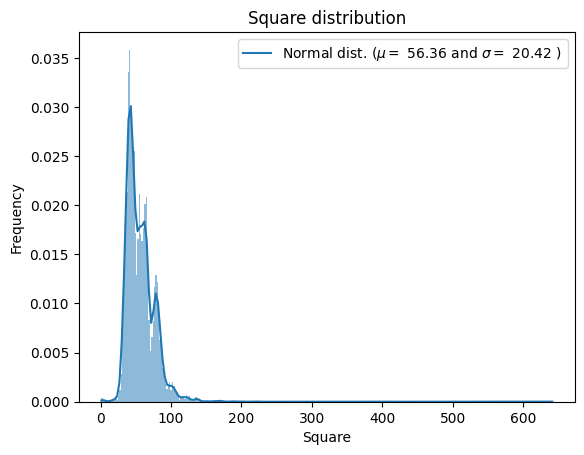

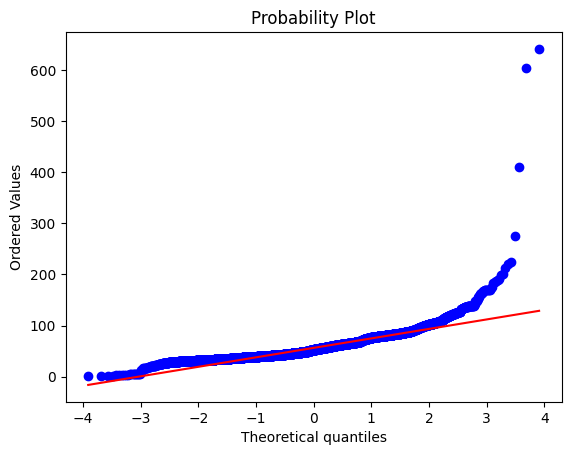

In [132]:
# Нормальное распределение целевой переменной

sns.histplot(all_data['Square'], kde=True, stat="density", linewidth=0)

# Подгонка нормального распределения
mu, sigma = norm.fit(all_data['Square'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend([f'Normal dist. ($\\mu=$ {mu:.2f} and $\\sigma=$ {sigma:.2f} )'])
plt.ylabel('Frequency')
plt.title('Square distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['Square'], plot=plt)
plt.show()

mu = 12.19 and sigma = 0.41


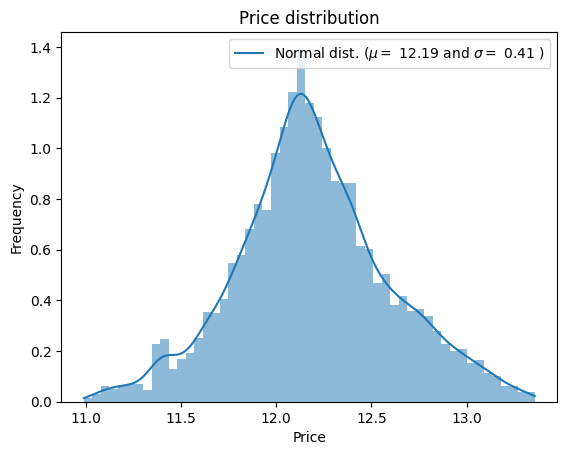

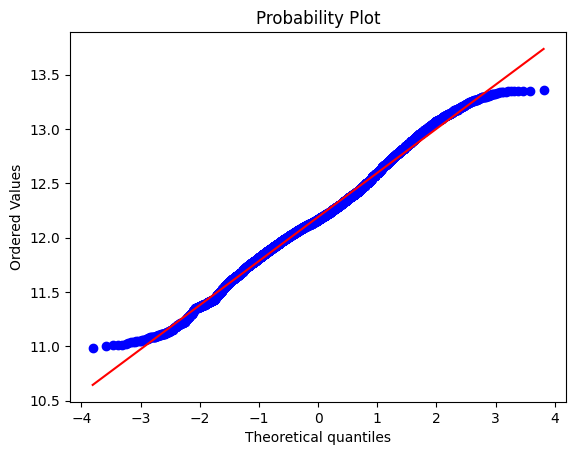

In [133]:
# Логарифмическое распределение целевой переменной
price_log = np.log1p(train['Price'])

# Плотность распределения с наложением нормального распределения
sns.histplot(price_log, kde=True, stat="density", linewidth=0)

# Подгонка нормального распределения
mu, sigma = norm.fit(price_log)

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend([f'Normal dist. ($\\mu=$ {mu:.2f} and $\\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

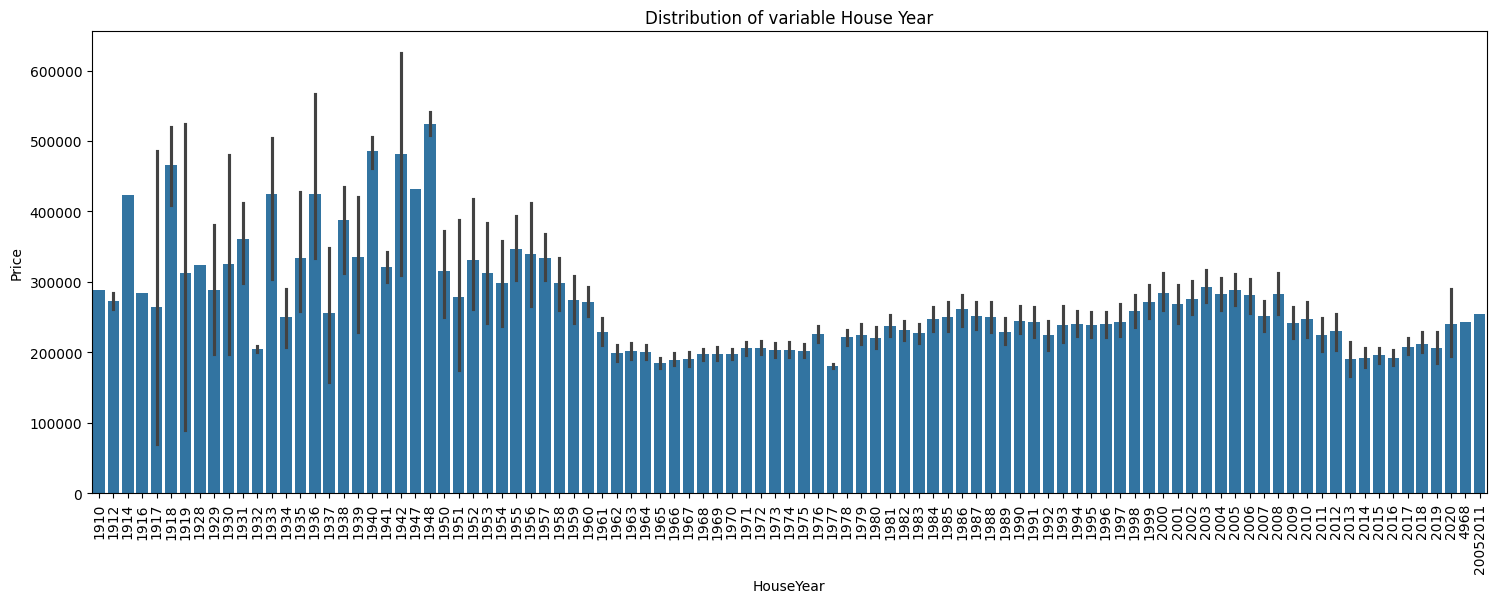

In [134]:
# Распределение "Дом Год"
plt.figure(figsize=(18, 6))
sns.barplot(x='HouseYear', y='Price', data=train)
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')
plt.show()

Text(0.5, 1.0, 'Distribution of variable District Id')

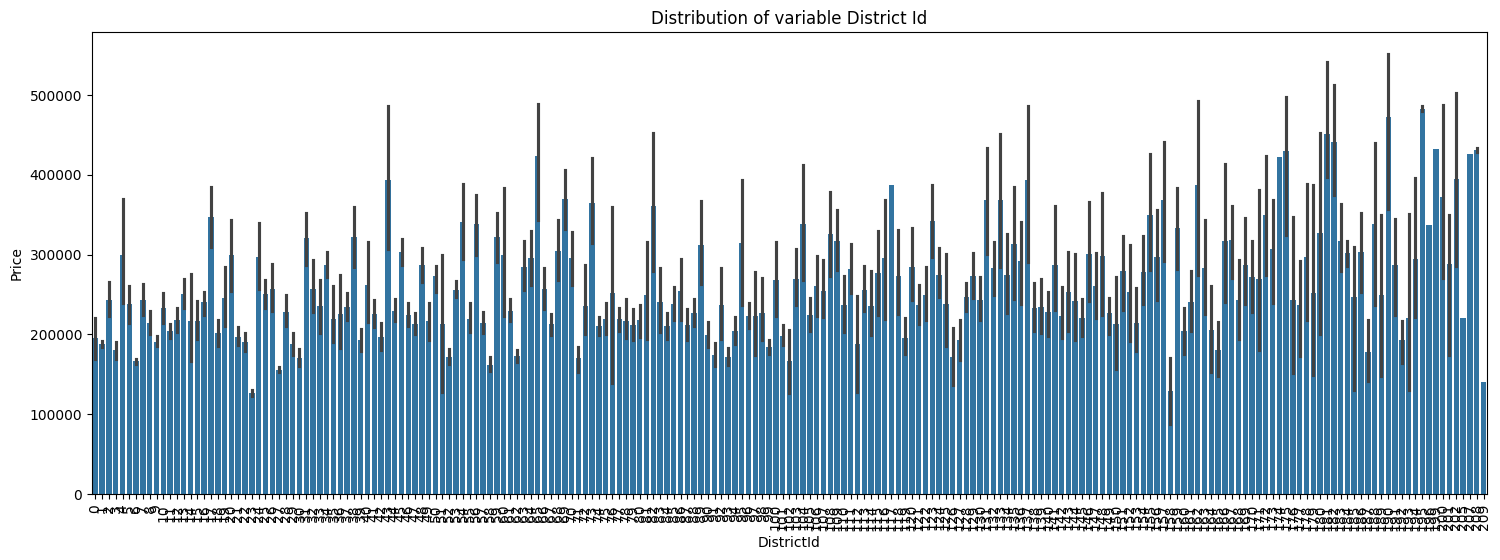

In [135]:
# распредиление "district ID"

plt.figure(figsize=(18, 6))
sns.barplot(x='DistrictId', y='Price', data=train)
plt.xticks(rotation=90)
plt.title('Distribution of variable District Id')

#### Отсутствующие данные

In [136]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [137]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

,Missing Ratio
Healthcare_1,47.833333
LifeSquare,21.026667


In [138]:
def df_del_missing(df):
    df_na = (df.isnull().sum() / len(df)) * 100

    df_na = df_na.drop(
        df_na[df_na == 0].index).sort_values(ascending=False)
    df_na = list(df_na.index)
    df.drop(df_na, axis=1, inplace=True)
    return df

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, Price]
Index: []


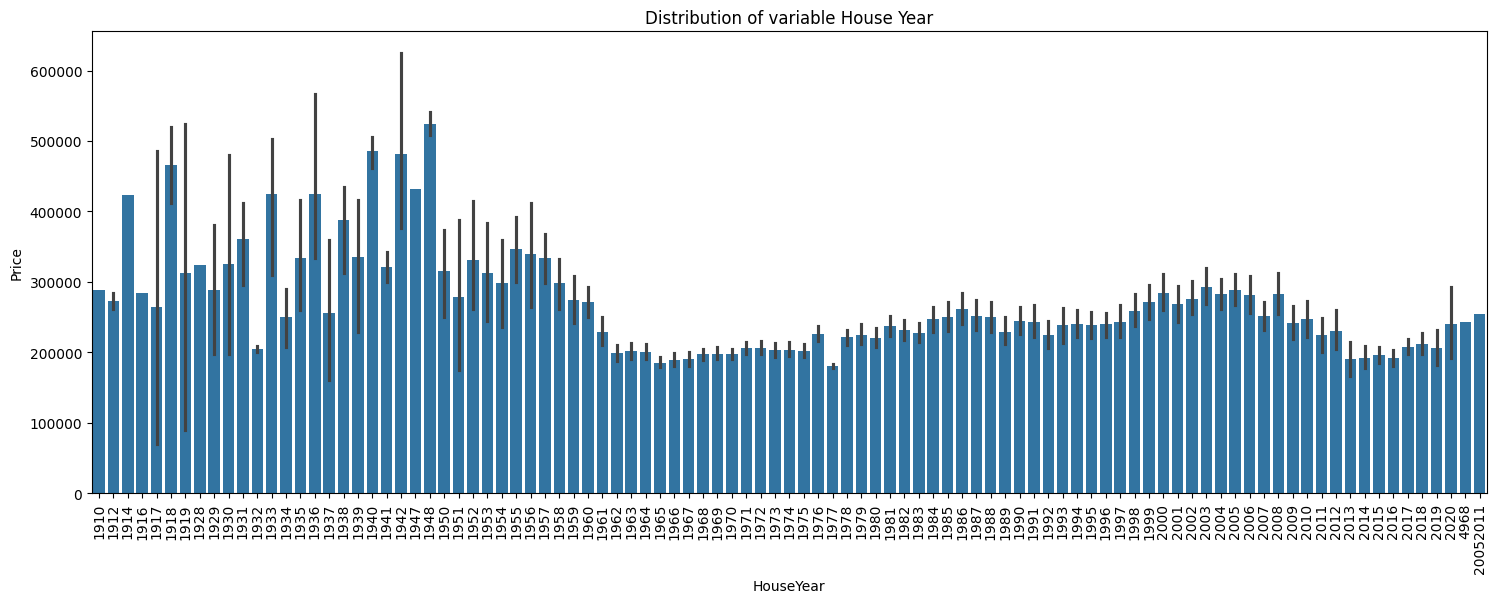

In [139]:
# кореляция данных

# Проверка на наличие нечисловых данных в 'Price'
non_numeric_values = train[~train['Price'].apply(lambda x: isinstance(x, (int, float)))]
print(non_numeric_values)

# Если обнаружены некорректные данные
train = train[train['Price'].apply(lambda x: isinstance(x, (int, float)))]

plt.figure(figsize=(18, 6))
sns.barplot(x='HouseYear', y='Price', data=train)
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')
plt.show()

In [140]:
non_numeric_values = train[~train['Price'].apply(lambda x: isinstance(x, (int, float)))]
print(non_numeric_values)


Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2, Price]
Index: []


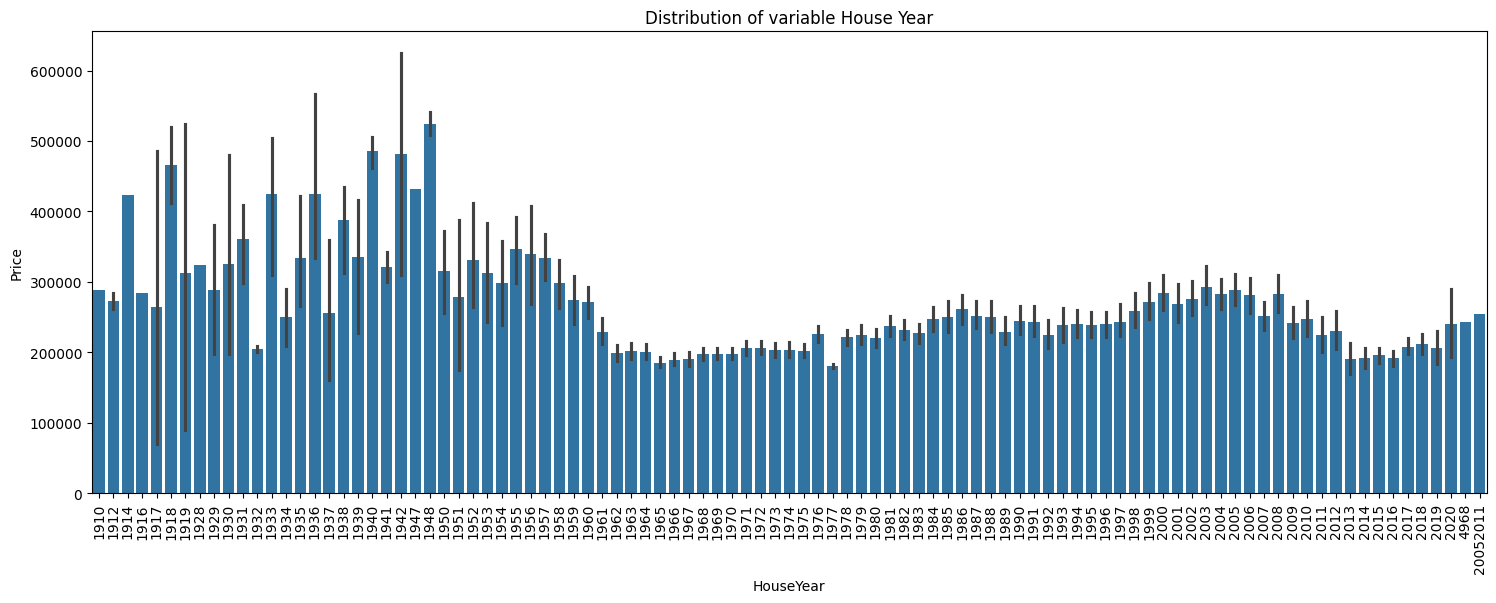

In [141]:
train = train[train['Price'].apply(lambda x: isinstance(x, (int, float)))]


plt.figure(figsize=(18, 6))
sns.barplot(x='HouseYear', y='Price', data=train)
plt.xticks(rotation=90)
plt.title('Distribution of variable House Year')
plt.show()


In [142]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Кластер

In [143]:
scaler = MinMaxScaler()

In [144]:
train_cluster = train.copy()

In [145]:
train_cluster = df_fix_house_year_manual(train_cluster)

In [146]:
train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])

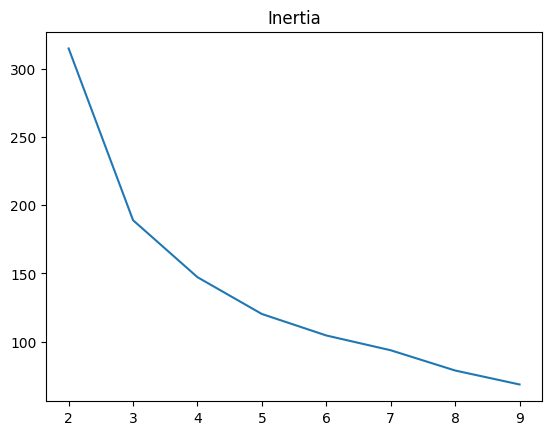

In [147]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_cluster_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)
plt.title('Inertia')

plt.show()

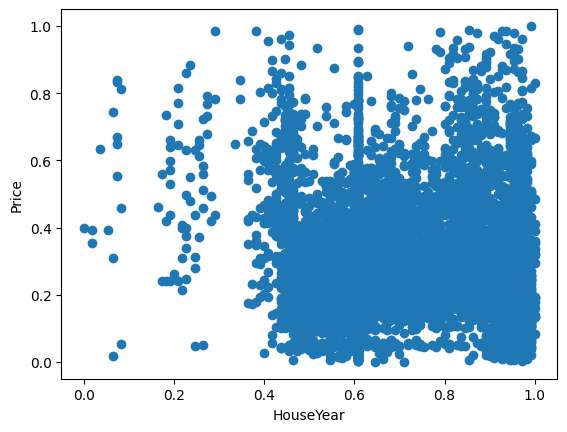

In [148]:
plt.scatter(train_cluster_scaled['HouseYear'], train_cluster_scaled['Price'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.show()

In [149]:
kmeans_model = KMeans(n_clusters=5, random_state=100)

In [150]:
train_labels = kmeans_model.fit_predict(train_cluster_scaled)

Text(0.5, 1.0, 'Train data')

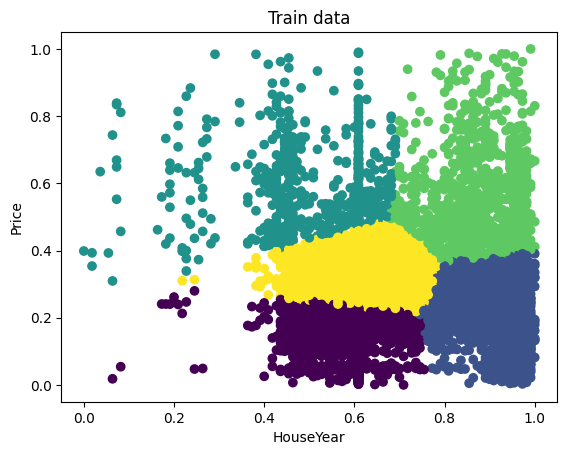

In [151]:
plt.scatter(train_cluster_scaled['HouseYear'],
            train_cluster_scaled['Price'], c=train_labels)

plt.xlabel('HouseYear')
plt.ylabel('Price')

plt.title('Train data')

In [152]:
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)

In [153]:
train_cluster['cluster_year'] = agglomerative_clustering_model.fit_predict(
    train_cluster_scaled)

Text(0.5, 1.0, 'Train')

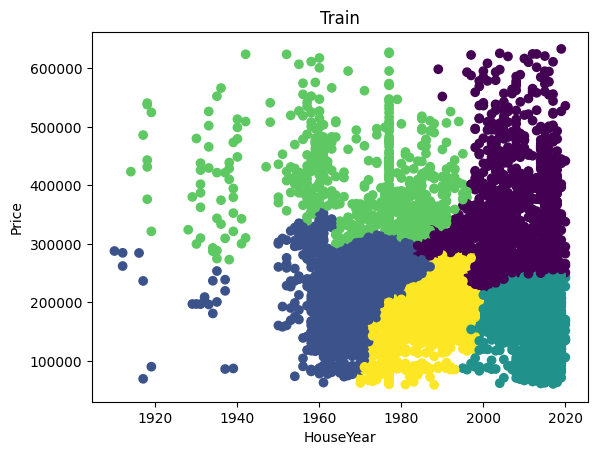

In [154]:
plt.scatter(train_cluster['HouseYear'],
            train_cluster['Price'], c=train_cluster['cluster_year'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.title('Train')

In [155]:
def add_cluster_year(df):
    df_scaled = pd.DataFrame(scaler.fit_transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['cluster_year'] = agglomerative_clustering_model.fit_predict(df_scaled)
    return df

#### Средняя цена по комнатам и средняя цена по районам ID и комнатам

In [156]:
def add_mean_price(df, df_train=train):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

In [157]:
def add_distr_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    return df

### модель

In [158]:
def data_prepare(df, df_train=train):
    df = df_fix_square_manual(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df)
    df = prepare_lifesquare(df)
    df = fillna_life_square(df)
    df = df_del_missing(df)
    df = add_cluster_year(df)
    df = add_mean_price(df, df_train)
    df = add_distr_info(df)
    df = pd.get_dummies(df)
    df.drop('mean_square_per_room_in_dr', axis=1, inplace=True)
    df.drop('mean_square_rooms_dr', axis=1, inplace=True)
    optimizing_df(df)
    return df


def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()


def model_top_deviation(model, test, valid):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred
    model_test['Price_test'] = valid
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test'])
    return model_test.nlargest(10, 'SD')

In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

In [168]:
print(train.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')


In [171]:
numeric_cols = train.select_dtypes(include=['number']).columns
features = list(train[numeric_cols].corrwith(train['Price']).abs().sort_values(ascending=False)[1:].index)
target = 'Price'

In [172]:
train[features].head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,Id,HouseYear
0,2,47.981560,35,33,0,7976,11,NaN,7,9,29.442751,5,0.089040,6.0,14038,1969
1,3,65.683640,41,46,1,10309,16,240.0,7,9,40.049541,1,0.000070,8.0,15053,1978
2,2,44.947952,53,34,1,7759,3,229.0,8,12,29.197611,0,0.049637,0.0,4765,1968
3,2,53.352982,58,23,0,5735,5,1084.0,8,17,52.731510,3,0.437885,9.0,5809,1977
4,1,39.649193,99,35,2,5776,4,2078.0,11,12,23.776169,1,0.012339,7.0,10783,1976


In [173]:
models_dict = {}

In [176]:
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.3, random_state=42)

In [180]:
print(X_train.columns)  # Проверьте, что 'DistrictId' есть в df
print(X_test.columns)  # Проверьте, что 'DistrictId' есть в distr_info


Index(['Rooms', 'Square', 'DistrictId', 'Social_1', 'Helthcare_2', 'Social_2',
       'Shops_1', 'Healthcare_1', 'Floor', 'HouseFloor', 'LifeSquare',
       'Social_3', 'Ecology_1', 'KitchenSquare', 'Id', 'HouseYear'],
      dtype='object')
Index(['Rooms', 'Square', 'DistrictId', 'Social_1', 'Helthcare_2', 'Social_2',
       'Shops_1', 'Healthcare_1', 'Floor', 'HouseFloor', 'LifeSquare',
       'Social_3', 'Ecology_1', 'KitchenSquare', 'Id', 'HouseYear'],
      dtype='object')


In [185]:
X_train = data_prepare(X_train, train)
X_test = data_prepare(X_test, train)

/var/folders/19/sfn9pvpn39b3v4sbnz61mwz80000gn/T/ipykernel_22039/992073466.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 30.43654933 101.10274068 105.97681536 ...  66.08773526 100.89993457
  65.71704571]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
/var/folders/19/sfn9pvpn39b3v4sbnz61mwz80000gn/T/ipykernel_22039/336159299.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[101.10274068  96.05678558  34.29874039  33.63331152  80.28877258
  33.70091356  68.20694733  61.67356873  32.67723743  33.63331152
  30.69230534  65.35447485  50.38062032  74.39392853  59.86635208
  28.43879318  86.62664032 200.33453369  75.49938202  33.20519671
  32.67723743  33.63331152  33.70091356  30.94341764  44.260

KeyError: 'DistrictId'

In [186]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 9069 to 7270
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          7000 non-null   uint8  
 1   Square         7000 non-null   float32
 2   DistrictId     7000 non-null   uint8  
 3   Social_1       7000 non-null   uint8  
 4   Helthcare_2    7000 non-null   uint8  
 5   Social_2       7000 non-null   uint16 
 6   Shops_1        7000 non-null   uint8  
 7   Healthcare_1   3642 non-null   float32
 8   Floor          7000 non-null   uint8  
 9   HouseFloor     7000 non-null   uint8  
 10  LifeSquare     5514 non-null   float32
 11  Social_3       7000 non-null   uint8  
 12  Ecology_1      7000 non-null   float32
 13  KitchenSquare  7000 non-null   float32
 14  Id             7000 non-null   uint16 
 15  HouseYear      7000 non-null   uint32 
dtypes: float32(5), uint16(2), uint32(1), uint8(8)
memory usage: 300.8 KB


In [187]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 6252 to 4705
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          3000 non-null   uint8  
 1   Square         3000 non-null   float32
 2   DistrictId     3000 non-null   uint8  
 3   Social_1       3000 non-null   uint8  
 4   Helthcare_2    3000 non-null   uint8  
 5   Social_2       3000 non-null   uint16 
 6   Shops_1        3000 non-null   uint8  
 7   Healthcare_1   1560 non-null   float32
 8   Floor          3000 non-null   uint8  
 9   HouseFloor     3000 non-null   uint8  
 10  LifeSquare     2373 non-null   float32
 11  Social_3       3000 non-null   uint8  
 12  Ecology_1      3000 non-null   float32
 13  KitchenSquare  3000 non-null   float32
 14  Id             3000 non-null   uint16 
 15  HouseYear      3000 non-null   uint32 
dtypes: float32(5), uint16(2), uint32(1), uint8(8)
memory usage: 128.9 KB


In [188]:
X_train.head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,Id,HouseYear
9069,1,41.681381,23,6,0,1437,2,NaN,14,17,22.796165,3,0.075779,8.0,14604,2015
2603,3,163.495331,23,2,0,475,0,NaN,5,3,161.504227,0,0.014073,12.0,5621,1977
7738,1,39.710133,87,43,1,7227,6,NaN,4,17,19.538664,0,0.100456,8.0,235,1986
1579,3,96.056786,48,46,1,9515,10,NaN,15,1,98.152802,5,0.041125,1.0,16258,2017
5058,3,79.195824,77,16,1,4048,3,NaN,16,17,44.421062,3,0.298205,10.0,10773,1984


In [189]:
y_train.head()

9069     88504.384965
2603    207007.956663
7738    182126.280899
1579    524365.550705
5058    322048.433990
Name: Price, dtype: float64

###  линейная регрессия

In [ ]:
line_regression_model = LinearRegression()
line_regression_model.fit(X_train, y_train)

In [191]:
models_dict['Linear Regression'] = line_regression_model

In [ ]:
model_test(line_regression_model, 'Linear Regression', X_test, y_test)

In [ ]:
model_top_deviation(line_regression_model, X_test, y_test)

In [194]:
random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(X_train, y_train)

RandomForestRegressor()

In [195]:
models_dict['Random Forest Regressor'] = random_forest_regressor_model

#### тест метода случайного леса

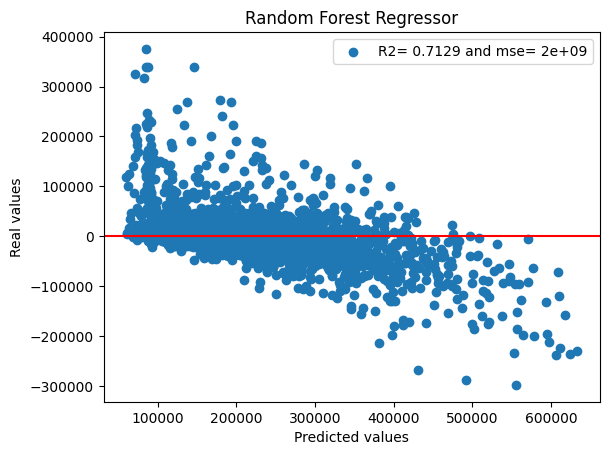

In [196]:
model_test(random_forest_regressor_model,
           'Random Forest Regressor', X_test, y_test)

In [197]:
model_top_deviation(random_forest_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,Id,HouseYear,Price,Price_test,SD
1606,3,78.188446,143,18,3,3746,1,75.0,17,16,44.663406,9,0.049863,10.0,6944,1983,460408.379537,84808.029433,375600.350104
9962,2,63.131653,158,37,2,6856,5,1940.0,9,8,41.867912,84,0.042032,8.0,4660,1939,427561.364808,87268.098968,340293.265840
132,3,110.203972,108,37,5,7687,5,176.0,19,28,59.270702,11,0.019509,12.0,3428,2007,485119.696478,146061.730565,339057.965913
4442,3,88.978325,152,37,2,6856,5,1940.0,7,7,56.939045,84,0.042032,12.0,14825,1958,423910.606798,85499.969325,338410.637473
696,3,94.417145,113,24,0,5469,1,145.0,6,18,56.749168,1,0.050756,11.0,7590,2008,397141.551813,71057.273346,326084.278467
3723,4,101.554253,33,17,2,4017,0,800.0,4,5,22.630373,7,0.051942,9.0,203,1958,399968.452561,82342.775873,317625.676688
6117,3,54.036552,17,23,2,4635,4,3300.0,6,21,43.891273,5,0.093443,8.0,5632,2017,257803.586571,556053.820499,298250.233929
8181,1,66.144440,24,50,2,12238,3,1970.0,1,18,23.803701,8,0.111627,18.0,11887,2007,204403.702837,491816.404219,287412.701382
7728,3,126.621361,24,50,2,12238,3,1970.0,22,48,62.455482,8,0.111627,12.0,7453,2011,451977.141992,179396.521035,272580.620957
6740,3,102.056969,9,25,2,5648,4,30.0,2,17,105.272339,1,0.161532,10.0,4802,2014,407109.048210,136963.323425,270145.724786


In [ ]:
gradient_boosting_regressor_model = GradientBoostingRegressor()
gradient_boosting_regressor_model.fit(X_train, y_train)

In [199]:
models_dict['Gradient Boosting Regressor'] = gradient_boosting_regressor_model

In [ ]:
model_test(gradient_boosting_regressor_model,
           'Gradient Boosting Regressor', X_test, y_test)

In [ ]:
model_top_deviation(gradient_boosting_regressor_model, X_test, y_test)

In [211]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV

imputer = SimpleImputer(strategy='mean')


lasso_cv_model = Pipeline([
        ('imputer', imputer),
        ('lasso', LassoCV())
    ])

lasso_cv_model.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('lasso', LassoCV())])

In [ ]:
#lasso_cv_model = LassoCV()
#lasso_cv_model.fit(X_train, y_train)

In [212]:
models_dict['LassoCV'] = lasso_cv_model

#### тест LassoCV

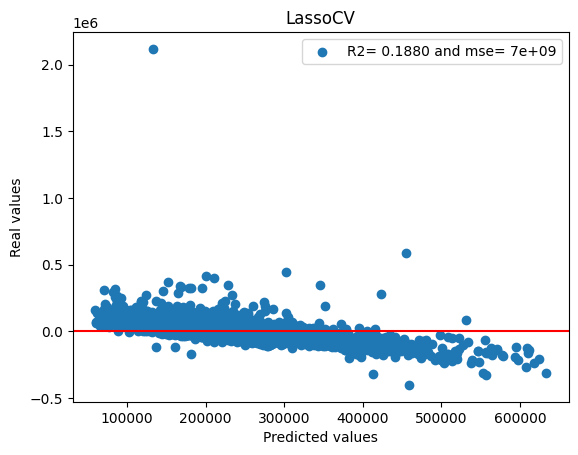

In [213]:
model_test(lasso_cv_model, 'LassoCV', X_test, y_test)

In [214]:
model_top_deviation(lasso_cv_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,Id,HouseYear,Price,Price_test,SD
6977,2,641.065186,30,22,3,6398,23,1046.0,20,19,638.163208,141,0.000078,10.0,11602,2019,2.251331e+06,133529.681562,2.117801e+06
1982,5,275.645294,86,31,3,7010,7,4508.0,12,37,233.949310,5,0.161976,26.0,5548,2011,1.038569e+06,455264.882666,5.833045e+05
1981,0,212.932358,27,9,0,1892,1,NaN,2,3,211.231125,0,0.211401,0.0,7917,2008,7.435697e+05,302211.260887,4.413584e+05
3651,3,169.509933,30,22,3,6398,23,1046.0,2,2,170.713654,141,0.000078,1.0,5300,2018,6.184072e+05,200800.673767,4.176065e+05
8283,1,1.988943,34,53,1,13670,11,NaN,21,4,2.642219,4,0.069753,1.0,15744,1977,5.525735e+04,458378.777006,4.031214e+05
8131,3,167.767029,93,0,0,186,0,NaN,1,1,NaN,0,0.004949,1.0,4991,1977,6.132667e+05,211180.794219,4.020859e+05
5421,2,148.671936,23,2,0,475,0,NaN,1,3,100.201653,0,0.014073,1.0,1205,2013,5.182455e+05,152464.848743,3.657807e+05
4047,1,163.286972,23,2,0,475,0,NaN,4,3,161.155273,0,0.014073,1.0,15362,1977,5.737863e+05,228572.520347,3.452138e+05
8511,5,198.930176,23,2,0,475,0,NaN,1,2,123.139862,0,0.014073,10.0,4249,2011,6.901749e+05,345665.209100,3.445097e+05
7930,3,135.020523,30,22,3,6398,23,1046.0,2,4,NaN,141,0.000078,1.0,9098,1977,5.062172e+05,167269.566699,3.389476e+05


In [215]:
all_data.loc[all_data['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
7,11993,74,2,80.312927,NaN,0.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
8,5172,1,2,64.511436,NaN,1.0,9,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B
12,6452,13,2,54.522804,31.759752,1.0,8,12,1999,0.090799,B,B,74,19083,2,NaN,5,15,B
14,10953,27,1,53.769096,52.408028,1.0,5,4,1977,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14982,12920,23,1,39.610428,38.187572,1.0,6,18,2013,0.034656,B,B,0,168,0,NaN,0,0,B
14985,11732,1,1,46.597282,NaN,1.0,17,24,1977,0.007122,B,B,1,264,0,NaN,0,1,B
14987,5361,53,3,80.102104,NaN,1.0,13,22,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
14998,4780,62,2,81.305222,NaN,0.0,4,0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


### LGBM

In [216]:
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1409
[LightGBM] [Info] Number of data points in the train set: 3118, number of used features: 16
[LightGBM] [Info] Start training from score 235036.390346


LGBMRegressor()

#### тест LGBMRegressor

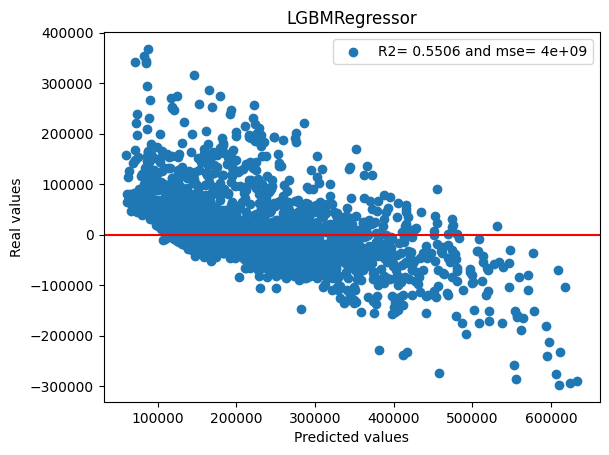

In [217]:
model_test(lgbm_regressor_model, 'LGBMRegressor', X_test, y_test)

In [218]:
model_top_deviation(lgbm_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,Id,HouseYear,Price,Price_test,SD
9962,2,63.131653,158,37,2,6856,5,1940.0,9,8,41.867912,84,0.042032,8.0,4660,1939,455135.172589,87268.098968,367867.073621
3723,4,101.554253,33,17,2,4017,0,800.0,4,5,22.630373,7,0.051942,9.0,203,1958,436220.787602,82342.775873,353878.011729
1606,3,78.188446,143,18,3,3746,1,75.0,17,16,44.663406,9,0.049863,10.0,6944,1983,427856.095834,84808.029433,343048.066401
696,3,94.417145,113,24,0,5469,1,145.0,6,18,56.749168,1,0.050756,11.0,7590,2008,412348.476929,71057.273346,341291.203583
4442,3,88.978325,152,37,2,6856,5,1940.0,7,7,56.939045,84,0.042032,12.0,14825,1958,424580.894187,85499.969325,339080.924862
132,3,110.203972,108,37,5,7687,5,176.0,19,28,59.270702,11,0.019509,12.0,3428,2007,462018.501246,146061.730565,315956.770681
3937,3,106.867638,146,16,3,3893,10,NaN,4,22,64.341759,27,0.236108,14.0,6808,2011,313075.070153,610557.405615,297482.335462
2826,3,69.250435,79,19,2,3856,5,NaN,5,5,51.165665,10,0.169091,6.0,5662,1937,381440.606437,86354.041813,295086.564624
8501,4,99.039162,95,14,0,3369,3,4129.0,2,3,71.575836,24,0.000699,11.0,7275,1942,329535.135276,624156.003381,294620.868105
6794,2,73.210350,73,37,2,6856,5,1940.0,16,17,NaN,84,0.042032,1.0,13226,2019,344004.897122,633233.466570,289228.569448


#### Tunning LGBMRegressor

In [219]:
lgbm_regressor_model.get_params

<bound method LGBMModel.get_params of LGBMRegressor()>

In [220]:
np.arange(0.01, 0.05, 0.01)

array([0.01, 0.02, 0.03, 0.04])

In [221]:
parameters = [{
    'max_bin': np.arange(90, 120, 10),
    'n_estimators': np.arange(4000, 7000, 1000),
    'learning_rate': np.arange(0.01, 0.05, 0.01)
}]

In [222]:
clf = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=4,
    n_jobs=-1,
)

In [223]:
clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 3118, number of used features: 16
[LightGBM] [Info] Start training from score 235036.390346


GridSearchCV(cv=4, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'learning_rate': array([0.01, 0.02, 0.03, 0.04]),
                          'max_bin': array([ 90, 100, 110]),
                          'n_estimators': array([4000, 5000, 6000])}],
             scoring='neg_mean_squared_error')

In [224]:
cv_results = pd.DataFrame(clf.cv_results_)
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(10)

,param_learning_rate,param_max_bin,param_n_estimators,mean_test_score
6,0.01,110,4000,-3.290485e+09
7,0.01,110,5000,-3.316875e+09
0,0.01,90,4000,-3.318223e+09
3,0.01,100,4000,-3.329207e+09
8,0.01,110,6000,-3.339736e+09
1,0.01,90,5000,-3.357398e+09
4,0.01,100,5000,-3.364423e+09
15,0.02,110,4000,-3.364480e+09
16,0.02,110,5000,-3.378397e+09
2,0.01,90,6000,-3.379227e+09


In [225]:
clf.best_params_

{'learning_rate': np.float64(0.01),
 'max_bin': np.int64(110),
 'n_estimators': np.int64(4000)}

#### тест tuning LGBMRegressor

In [226]:
lgbm_regressor_model = LGBMRegressor(
    max_bin=110,
    num_leaves=4,
    n_estimators=4000,
    learning_rate=0.01
)
lgbm_regressor_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 3118, number of used features: 16
[LightGBM] [Info] Start training from score 235036.390346


LGBMRegressor(learning_rate=0.01, max_bin=110, n_estimators=4000, num_leaves=4)

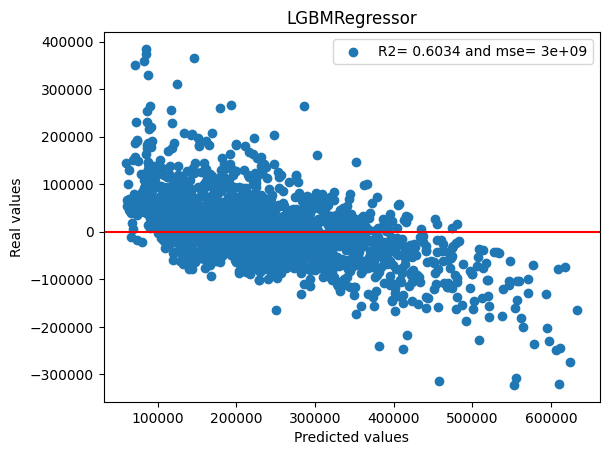

In [227]:
model_test(lgbm_regressor_model, 'LGBMRegressor', X_test, y_test)

In [228]:
models_dict['LGBMRegressor'] = lgbm_regressor_model

### XGBRegressor

In [229]:
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [230]:
models_dict['XGBRegressor'] = xgboost_model

#### Test XGBRegressor

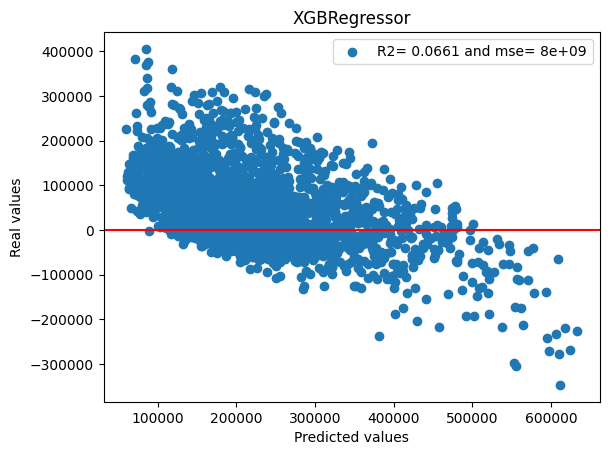

In [231]:
model_test(xgboost_model, 'XGBRegressor', X_test, y_test)

In [232]:
model_top_deviation(xgboost_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,Id,HouseYear,Price,Price_test,SD
1606,3,78.188446,143,18,3,3746,1,75.0,17,16,44.663406,9,0.049863,10.0,6944,1983,489770.87500,84808.029433,404962.845567
696,3,94.417145,113,24,0,5469,1,145.0,6,18,56.749168,1,0.050756,11.0,7590,2008,453834.50000,71057.273346,382777.226654
9962,2,63.131653,158,37,2,6856,5,1940.0,9,8,41.867912,84,0.042032,8.0,4660,1939,463471.06250,87268.098968,376202.963532
4442,3,88.978325,152,37,2,6856,5,1940.0,7,7,56.939045,84,0.042032,12.0,14825,1958,454533.40625,85499.969325,369033.436925
6486,3,76.974762,18,30,0,5562,5,NaN,12,17,46.767570,0,0.000000,10.0,15395,1999,478869.90625,118664.442968,360205.463282
9828,3,127.141144,24,50,2,12238,3,1970.0,3,1,4.811405,8,0.111627,1.0,13630,2017,264220.78125,611250.912034,347030.130784
7089,3,76.415077,83,43,1,7227,6,NaN,18,16,48.578346,0,0.100456,10.0,8292,1987,427398.21875,86975.007476,340423.211274
8683,3,86.329590,27,53,1,14892,4,NaN,6,7,47.127872,4,0.041116,8.0,5182,2003,437159.75000,117535.415755,319624.334245
7728,3,126.621361,24,50,2,12238,3,1970.0,22,48,62.455482,8,0.111627,12.0,7453,2011,498430.96875,179396.521035,319034.447715
2826,3,69.250435,79,19,2,3856,5,NaN,5,5,51.165665,10,0.169091,6.0,5662,1937,403979.62500,86354.041813,317625.583187


## итог

In [249]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [250]:
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = r2_score(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

### Выбор модели

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

# Обработка пропущенных значений
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

def models_r2(models, X, y):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        try:
            test_pred = model.predict(X)
            r2 = r2_score(y, test_pred)
            mse = mean_squared_error(y, test_pred)
            scores = scores.append({'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
        except Exception as e:
            print(f"Error evaluating model {name}: {e}")
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

# Оцените модели
models_score_test = models_r2(models_dict, X_test_imputed, y_test)
models_score_train = models_r2(models_dict, X_train_imputed, y_train)
   
   

In [ ]:
models_score_test = models_r2(models_dict, X_test, y_test)
models_score_train = models_r2(models_dict, X_train, y_train)

In [ ]:
models_score_test[['name', 'r2']]

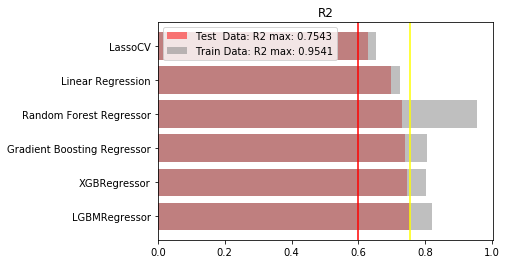

In [102]:
r2_max_test = models_score_test['r2'].max()
r2_max_train = models_score_train['r2'].max()
plt.barh(models_score_test['name'], models_score_test['r2'],
         alpha=0.5, color='red', label=f'Test  Data: R2 max: {r2_max_test:.4f}')
plt.barh(models_score_train['name'], models_score_train['r2'],
         alpha=0.5, color='grey', label=f'Train Data: R2 max: {r2_max_train:.4f}')
plt.title('R2')
plt.legend()
plt.axvline(0.6, color='red')
plt.axvline(r2_max_test, color='yellow')
plt.show()

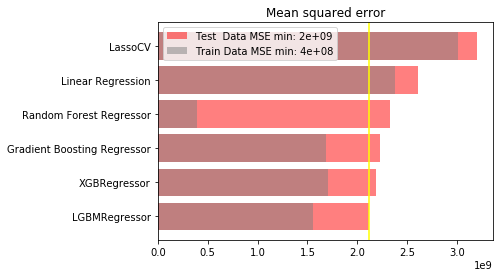

In [103]:
mse_min_test = models_score_test['mse'].min()
mse_min_train = models_score_train['mse'].min()
plt.barh(models_score_test['name'], models_score_test['mse'],
         alpha=0.5, color='red', label=f'Test  Data MSE min: {mse_min_test:.0e}')
plt.barh(models_score_train['name'], models_score_train['mse'],
         alpha=0.5, color='grey', label=f'Train Data MSE min: {mse_min_train:.0e}')
plt.title('Mean squared error')
plt.legend(loc=2)
plt.axvline(mse_min_test, color='yellow')
plt.show()

In [104]:
best_model = models_dict['LGBMRegressor']

In [105]:
pd.DataFrame({'name': list(X_train.columns),
              'importances': list(best_model.feature_importances_)})

,name,importances
0,Rooms,583
1,Square,1616
2,DistrictId,514
3,Social_1,622
4,Helthcare_2,105
5,Social_2,422
6,Shops_1,359
7,Floor,415
8,HouseFloor,780
9,LifeSquare,455


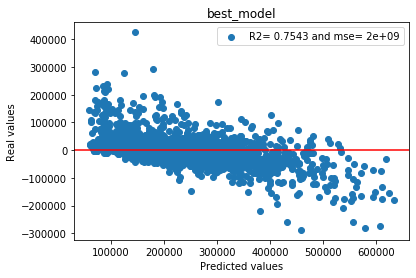

In [106]:
model_test(best_model, 'best_model', X_test, y_test)

## Output Files

In [ ]:
test = data_prepare(test)

In [260]:
test_features = list(X_train.columns)

In [261]:
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   uint8  
 1   Square         5000 non-null   float32
 2   DistrictId     5000 non-null   uint8  
 3   Social_1       5000 non-null   uint8  
 4   Helthcare_2    5000 non-null   uint8  
 5   Social_2       5000 non-null   uint16 
 6   Shops_1        5000 non-null   uint8  
 7   Healthcare_1   2623 non-null   float32
 8   Floor          5000 non-null   uint8  
 9   HouseFloor     5000 non-null   uint8  
 10  LifeSquare     3959 non-null   float32
 11  Social_3       5000 non-null   uint8  
 12  Ecology_1      5000 non-null   float32
 13  KitchenSquare  5000 non-null   float32
 14  Id             5000 non-null   uint16 
 15  HouseYear      5000 non-null   uint16 
dtypes: float32(5), uint16(3), uint8(8)
memory usage: 166.1 KB


In [ ]:
test['Price'] = best_model.predict(test[test_features])

In [ ]:
price_log = np.log1p(test['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(test['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

In [ ]:
test[['Id', 'Price']].to_csv('ou_prediction.csv', index=None)